<a href="https://colab.research.google.com/github/mertent/ml-2/blob/main/Sprint2_Toon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [25, 15]

# Creating the dataset

In [ ]:
from google.colab import auth

import pandas as pd
import numpy as np

import os
import csv

import librosa

project_id = 'ml-project-309813'
bucket_name = 'ml_sprint2_mp3'

def init_cloud():
  auth.authenticate_user()

  !gcloud config set project {project_id}

def download_from_cloud(filepath, unzip = False):
  init_cloud()
  filename = filepath.split('/')[-1]
  !gsutil cp gs://{bucket_name}/$filepath .
  if unzip:
    !unzip -q $filename
    !rm $filename

def upload_to_cloud(filename, zip = False):
  init_cloud()
  if zip:
    zipname = '{}.zip'.format(filename)
    !zip $zipname $filename
    !gsutil cp $zipname gs://{bucket_name}/
    !rm $zipname
  else:
    !gsutil cp $filename gs://{bucket_name}/

### Loading the data

In [ ]:
download_from_cloud('samples/samples.zip', unzip = True)

Updated property [core/project].
Copying gs://ml_sprint2_mp3/samples/samples.zip...
| [1 files][ 19.8 GiB/ 19.8 GiB]   53.4 MiB/s                                   
Operation completed over 1 objects/19.8 GiB.                                     


In [ ]:
download_from_cloud('tracks_with_sample.pkl.zip', unzip = True)

Updated property [core/project].
Copying gs://ml_sprint2_mp3/tracks_with_sample.pkl.zip...
/ [1 files][  6.8 MiB/  6.8 MiB]                                                
Operation completed over 1 objects/6.8 MiB.                                      


In [ ]:
df = pd.read_pickle('tracks_with_sample.pkl')[['track_id', 'instrumentalness']]

### Extracting features

In [ ]:
header = 'track_id chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

#### For the complete tracks

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for track in os.listdir('samples/'):
  y, sr = librosa.load('samples/'+track, mono = True)
  chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
  rmse = librosa.feature.rms(y = y)
  spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
  spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
  spec_roll = librosa.feature.spectral_rolloff(y = y, sr = sr)
  zcr = librosa.feature.zero_crossing_rate(y = y)
  to_append = f'{track[:-4]} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_roll)} {np.mean(zcr)}'
  
  mfcc = librosa.feature.mfcc(y = y, sr = sr)
  for e in mfcc:
    to_append += f' {np.mean(e)}'

  file = open('data.csv', 'a', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

#### When split into 1s samples

In [ ]:
header = 'track_id part chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

In [ ]:
file = open('data_split.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

os.mkdir('splits/')
for track in df['track_id'].tolist():
  os.mkdir('splits/{}/'.format(track))
  song = AudioSegment.from_mp3('samples/'+track+'.mp3')
  for i in range(0, 29):
    part = song[i*1000: (i+1)*1000]
    part.export('splits/{}/{}.mp3'.format(track, i), format = 'mp3')
  for part_name in os.listdir('splits/{}/'.format(track)):
    y, sr = librosa.load('splits/{}/{}'.format(track, part_name), mono = True)
    chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
    rmse = librosa.feature.rms(y = y)
    spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
    spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
    spec_roll = librosa.feature.spectral_rolloff(y = y, sr = sr)
    zcr = librosa.feature.zero_crossing_rate(y = y)
    to_append = f'{track} {part_name[:-4]} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_roll)} {np.mean(zcr)}'
    
    mfcc = librosa.feature.mfcc(y = y, sr = sr)
    for e in mfcc:
      to_append += f' {np.mean(e)}'

    file = open('data_split.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

### Controll


In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
A = set(data['track_id'].tolist())
B = set(df['track_id'].tolist())
C = B - A
print(C)
print(len(C))

{'7IfPoktoKUudmVNbOHgBHB', '0NXV6jrvQIpAdZeW9HGvAw', '0ZZsc7a8sB635fzl6mP09J', '0Alupzs5jH43gNsvGDycFO', '79rOnFkYiBBlcCzUMc9HQo', '05q4O7MpORfUiXN2oX9K0b', '5o8vqE25Ie5A5kRZTW0hW0', '2rl6DoB1gedRZPtavWjkUD', '5YjKt620BpDdWt0R2RzxWA', '4xdNmYWQFo0ISB7jbTZzMh', '5JG1F5JVHsO7Sk6UAo1Rb9', '0I1hGwd45zPE10Zxz97nKL', '0TXwOYYmyZBOmi75DPVQd8', '4lKYd0XPtaLz7gtLSNUwsi', '1i5XFIVdPhazNfyBjy4eyW', '4edDMfwBqA8kQdGZ5BxAWf', '1YtjDoYQ7MJV6m8q218zmu', '1AoQjGDs0zHskfiOS4xV8U', '0Nek8bANm0dzO0vI9mmnJG', '0mBbub4kfiQafIaShJcG9b', '0qBi8Q67J8rd1ZbNRTSe9e', '6DeGFcrDiYDuyV7e7KnqPd', '5IUtvfNvOyVYZUa6AJFrnP', '4DAPrMawRWWAuolDTs1Twx', '2aO44vRDoJcJY1wmH9EfZr', '2Nb2SSUnGfThgDyG9ZOAkS', '6Zz5roTd5pRgkrH7Mc8qdh', '08ridJsmOI6aii2YBuLbVc', '4JcZzQz2Pg3uXOMMAeJRLd', '5NkKft6y8AeXt37Y6dQAXY', '0KA5Hg6c1vEiulQ1f2LICV', '4s1FVhrkxU9YlpPWApxsVe', '4z9t2ni49794zKWO1v2eMh', '32BSF82GFRulOZzqWVbxeo', '0kIs5oIA1j2s9E0ZTjuwyA', '6KJ5NyWH3evIRqH4jMKGgK', '3iQNkoYyr2SffgYiTpE3v5', '1AOfWofGUgItRNewpDt5oC', '7LhwtSXsri

In [ ]:
for track in C:
  y, sr = librosa.load('samples/'+track+'.mp3', mono = True)
  chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
  rmse = librosa.feature.rms(y = y)
  spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
  spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
  spec_roll = librosa.feature.spectral_rolloff(y = y, sr = sr)
  zcr = librosa.feature.zero_crossing_rate(y = y)
  to_append = f'{track} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_roll)} {np.mean(zcr)}'
  
  mfcc = librosa.feature.mfcc(y = y, sr = sr)
  for e in mfcc:
    to_append += f' {np.mean(e)}'

  file = open('data.csv', 'a', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

# Predicting instrumentalness

## Data preprocessing

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
download_from_cloud('data.csv.zip', unzip = True)
download_from_cloud('tracks_with_sample.pkl.zip', True)

Updated property [core/project].
Copying gs://ml_sprint2_mp3/data.csv.zip...
/ [1 files][ 14.5 MiB/ 14.5 MiB]                                                
Operation completed over 1 objects/14.5 MiB.                                     
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Updated property [core/project].
Copying gs://ml_sprint2_mp3/tracks_with_sample.pkl.zip...
/ [1 files][  6.8 MiB/  6.8 MiB]                                                
Operation completed over 1 objects/6.8 MiB.                                      


In [ ]:
data = pd.read_csv('data.csv')
data.head()

,track_id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,7m7SLo5HUI0DyDXzMh8wNv,0.461419,0.349618,2747.332185,2554.214631,5601.416129,0.140665,56.223515,73.457298,-18.041945,26.415985,1.756558,9.851189,0.590065,7.277120,3.868406,13.852572,-2.941686,5.088948,-4.421315,2.747003,-3.081998,3.358888,-3.392253,3.239243,3.219959,4.650892
1,6d67dxOSfGKh5PdajyLSWm,0.483012,0.265985,2112.421234,2445.767968,4749.262949,0.059092,-78.577553,97.260010,15.902855,32.797787,0.600500,13.400225,-2.983642,9.846685,-8.518023,10.379026,-4.649569,4.574261,-2.577501,1.222419,3.834130,6.670552,1.522592,8.789327,3.231066,2.853462
2,6226wcHJbifKCqhN8ZCkMg,0.364345,0.188669,2068.356307,2349.537868,4540.447545,0.069081,-114.790535,96.585663,17.304708,30.451933,-4.400069,14.700328,-9.050969,2.998199,-5.182761,2.615429,-10.854939,0.760484,-3.946095,-0.060809,-6.774857,-1.057367,-4.474327,-0.674645,-7.189997,2.244162
3,2G4iTsdENLdVI8mWxZ6l6n,0.426456,0.225496,1913.436591,2018.147118,3826.718527,0.096819,-26.478724,117.908524,-29.189484,32.336597,2.403701,5.549382,-3.379838,13.127804,-3.544428,7.435021,-5.242411,6.120144,-3.433726,0.829871,-4.526956,2.918036,-4.669353,-0.692641,-2.682045,0.892190
4,2btKz4s1XrMn5VHe7xZJpi,0.396857,0.315556,2272.510277,2467.051733,4823.704165,0.086627,-64.377640,82.928268,-10.065195,21.885105,0.378192,2.787563,9.316062,-4.451181,2.910890,1.826487,2.448398,8.532267,-5.928687,13.032363,-6.220285,4.767183,-3.243019,3.177322,-7.358551,-0.178495


In [ ]:
tracks = pd.read_pickle('tracks_with_sample.pkl')[['track_id', 'instrumentalness']]
tracks.head()

,track_id,instrumentalness
1783335,1qe2MGMs3gw5QLJyGxjamb,0.000002
1783341,6ShK6JZDaeFxCnAAUXsfPI,0.000000
2141439,6f8VnQoKYM6daZXizkBN4D,0.019000
2141441,6PNaaoB0T160zO6brSoSqU,0.000030
2141443,6no5baGUKmDDpfO2eNDlaH,0.000002


In [ ]:
data = data.merge(tracks, how = 'right', on = 'track_id')
data.head()

,track_id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,instrumentalness
0,1qe2MGMs3gw5QLJyGxjamb,0.487117,0.246417,3081.501794,2766.079834,6404.452940,0.166556,19.950909,64.549850,-0.481773,30.597960,4.235433,8.293938,-1.822885,11.946126,-1.836666,7.592280,-1.691781,8.076308,-0.908381,2.502001,-4.968572,-1.060388,-7.522568,4.111219,-3.091797,1.251546,0.000002
1,6ShK6JZDaeFxCnAAUXsfPI,0.468857,0.234630,2753.867510,2726.693766,6073.704940,0.121577,-14.802080,73.925766,2.792113,32.486340,4.870519,15.820938,-4.450747,13.341476,0.207935,8.006951,-1.330467,6.311600,-1.170379,0.725233,-5.629426,2.414155,-5.234504,-0.348772,-3.764290,1.261043,0.000000
2,6f8VnQoKYM6daZXizkBN4D,0.414518,0.184286,2286.624585,2249.423353,4661.688478,0.123672,-49.485706,90.616959,-15.639648,49.880554,-1.508834,16.667583,0.448966,4.351577,3.663136,4.905038,-5.763404,8.730154,-4.215452,3.445769,0.150254,0.565031,-2.966372,3.894284,-1.797530,1.668712,0.019000
3,6PNaaoB0T160zO6brSoSqU,0.395598,0.202731,1713.089913,2218.201529,3711.002560,0.064289,-84.790535,117.376015,8.734200,34.086742,8.669621,9.612740,-0.279116,8.686201,-6.772654,6.608932,-0.475264,1.453128,-3.756169,0.653984,-4.197217,2.839889,-3.175522,0.727960,-3.859671,-0.491266,0.000030
4,6no5baGUKmDDpfO2eNDlaH,0.385372,0.189065,2384.023801,2459.883863,5144.552225,0.110455,-40.290878,86.348633,-3.049298,38.557789,0.334460,12.984218,-5.965024,2.461722,-3.215506,7.468392,2.060841,7.110326,-5.860871,1.761472,-2.749496,0.246150,-6.613864,0.627022,-4.612545,0.751032,0.000002


In [ ]:
data.drop('track_id', 1, inplace = True)
data.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,instrumentalness
count,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000,59105.000000
mean,0.407507,0.243641,2278.889434,2369.958829,4833.611954,0.098876,-65.051965,95.787382,-0.493254,24.178330,2.645044,9.282683,-1.406757,6.042961,-3.467816,5.294859,-3.156597,3.455025,-3.183403,2.053524,-3.343156,2.239051,-4.055422,2.069199,-3.048509,1.444229,0.236816
std,0.095559,0.088220,676.879096,516.083538,1517.307500,0.038838,90.514737,34.369438,20.744763,12.042711,8.890617,8.890651,6.899393,7.465712,6.818808,6.250460,5.312352,5.716687,4.700221,4.900236,4.316312,4.540486,4.143367,4.149818,3.804201,4.118049,0.361344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.370972,-71.483063,-161.741791,-120.033859,-85.223396,-64.133759,-55.786915,-56.953819,-60.580956,-38.991020,-45.927444,-38.039494,-28.674454,-33.418743,-38.767601,-27.624144,-32.749813,-24.812511,-32.987038,-30.989538,0.000000
25%,0.341832,0.187064,1910.384371,2193.064339,4050.708839,0.071953,-101.562233,73.731873,-12.645708,17.120121,-2.277611,4.917206,-5.166460,2.294917,-7.139151,2.167602,-6.110093,0.521347,-5.810100,-0.584007,-5.885688,-0.168354,-6.493582,-0.180330,-5.299371,-0.860122,0.000000
50%,0.399609,0.250895,2364.616994,2486.913789,5089.910889,0.097119,-46.913170,89.127434,-0.677713,24.237165,2.858645,10.192942,-0.944625,7.120025,-2.661878,6.180877,-2.656843,4.259828,-2.858941,2.519761,-3.232361,2.692725,-3.949119,2.404405,-2.896966,1.717407,0.000701
75%,0.466119,0.302524,2725.825481,2697.281772,5859.864566,0.123418,-2.946795,109.718216,11.160498,31.442585,7.934004,14.845001,2.926754,10.975424,1.090299,9.357345,0.295250,7.267013,-0.206565,5.253536,-0.615826,5.203911,-1.429603,4.749807,-0.673612,4.060105,0.529000
max,0.796428,0.720604,6067.477956,3565.027032,8859.771426,0.574138,110.356522,305.093750,164.009995,89.120941,65.608566,65.920868,54.087879,48.722202,42.957516,36.871845,51.984604,32.973701,34.547131,33.328106,26.216000,29.548653,22.242657,27.985247,22.486940,23.180933,1.000000


### Feature reduction

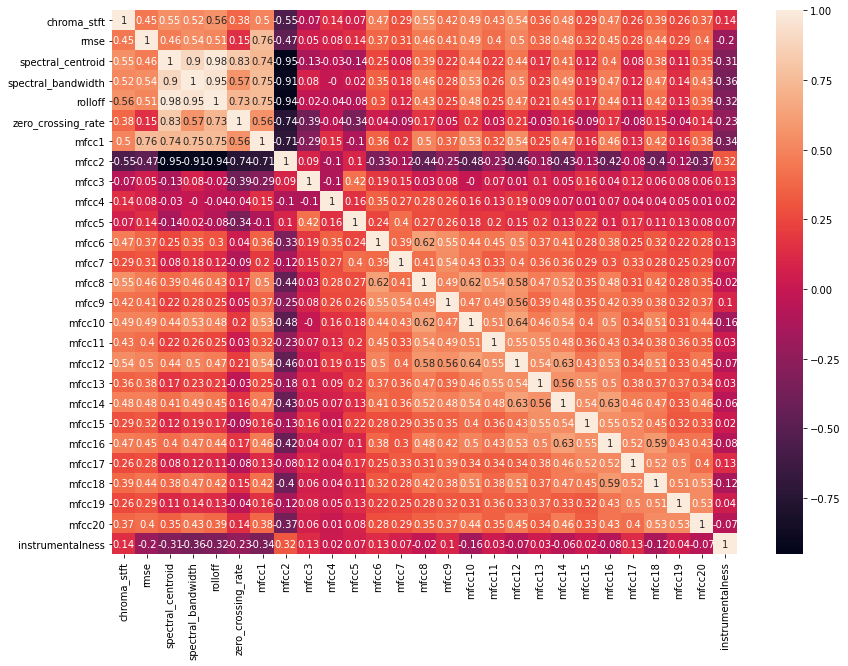

In [ ]:
correlation_matrix = data.corr().round(2)
plt.figure(figsize=(14,10))
sns.heatmap(data=correlation_matrix, annot=True)

In [ ]:
x = data.drop('instrumentalness', axis = 1)
y = data.instrumentalness
print(x.shape)
print(y.shape)

(59105, 26)
(59105,)


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(x)
Y = scaler.fit_transform(y.to_numpy().reshape(-1, 1))

Text(0, 0.5, 'cumulative explained variance')

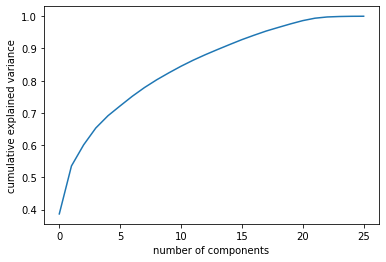

In [ ]:
pca = PCA()
data_reduced = pca.fit_transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Seems better without PCA

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15)
print(X_train.shape)
print(X_test.shape)

(50239, 26)
(8866, 26)


## Model

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [ ]:
basic_model = LinearRegression()

basic_model.fit(X_train, Y_train)

y_predictions = basic_model.predict(X_test)
print(basic_model.score(X_test, Y_test))

0.3941142561902352
0.3941142561902352


In [ ]:
pca = PCA(n_components=10)
lin = LinearRegression()

pca_model = make_pipeline(pca, lin)

param_grid = [{ 'pca__n_components': [2, 5, 10, 15, 20, 26], 'pca__whiten': ['True', 'False'] }]

search = GridSearchCV(pca_model, param_grid=param_grid, cv=5)
search.fit(X_train, Y_train)

print(search.best_params_)

pca_model = search.best_estimator_

print(pca_model.score(X_test, Y_test))

{'pca__n_components': 26, 'pca__whiten': 'True'}
0.3941142561902352


### Bayesian Regression

In [39]:
from sklearn.linear_model import BayesianRidge

bayes = BayesianRidge()
bayes.fit(X_train, Y_train)
print(bayes.score(X_test, Y_test))

0.3940214663675149


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SDGRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
sgd.fit(X_train, Y_train)
print(sgd.score(X_test, Y_test))

0.3911345812460023


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### MPLRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state = 1, max_iter = 500)
regressor.fit(X_train, Y_train)
print(regressor.score(X_test, Y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5530345073295668


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam', 'lbfs']}

model = MLPRegressor(random_state = 1, max_iter = 500)

search = GridSearchCV(model, param_grid = param_grid)
search.fit(X_train, Y_train)

print(search.best_params_)
print(search.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_m

# Genre classification - Complete tracks

## Data preprocessing

In [ ]:
data = pd.read_csv('data.csv')
tracks = pd.read_pickle('tracks_with_sample.pkl')
tracks = tracks[['track_id', 'genre']]

In [ ]:
genres = ['sad', 'happy', 'heavy-metal', 'k-pop', 'blues', 'alt-rock', 'classical', 'jazz', 'disco', 'drum-and-bass']

In [ ]:
tracks[tracks['genre'].isin(genres)].value_counts('genre').plot(kind = 'bar')

In [ ]:
data = data.merge(tracks, how = 'right', on = 'track_id')
data.drop(['track_id'], axis = 1, inplace = True)
data.head()

In [ ]:
x = data.drop(['genre'], axis = 1)
y = data['genre']
print(x.shape)
print(y.shape)

In [ ]:
x.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler
X = scaler.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.15)
print(X_train.shape)
print(X_test.shape)

## Model

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

### Linear SVM

In [ ]:
lin = svm.LinearSVC()
lin.fit(X_train, Y_train)
print(lin.score(X_test, Y_test))
plot_confusion_matrix(clf, X_test, Y_test)

### Grid search

In [ ]:
pca = PCA(n_components=15, whiten = True)
svm = svm.SVC(kernel = 'linear')

model = make_pipeline(pca, svm)

param_grid = [
              {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['rbf'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]}, 
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['poly'], 'svc__class_weight': [None, 'balanced'], 'svc__degree': [2, 3, 4, 5], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]},
              {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001], 'svc__kernel': ['sigmoid'], 'svc__class_weight': [None, 'balanced'], 'pca__n_components': [5, 10, 15, 20, 26], 'pca__whiten': [True, False]}
]

search = GridSearchCV(model, param_grid = param_grid)

search.fit(X_train, Y_train)

print(search.best_params_)
print(search.best_score_)

plot_confusion_matrix(search.best_estimator_, X_test, Y_test)

In [ ]:
#Output was

{'pca__n_components': 26, 'pca__whiten': True, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### RBF

In [ ]:
rbf = svm.SVC(C = 10, kernel = 'rbf', class_weight = 'balanced', gamma = 0.01)

rbf.fit(X_train, Y_train)

print(rbf.score(X_test, Y_test))
plot_confusion_matrix(rbf, X_test, Y_test)

# Genre classification - 1s samples

## Data preprocessing

In [ ]:
download_from_cloud('data_split.csv.zip', True)

In [ ]:
data = pd.read_csv('data_split.csv')
tracks = pd.read_pickle('tracks_with_sample.pkl')[['track_id', 'genre']]

In [ ]:
data = data.merge(tracks, how = 'right', on = 'track_id')
data.drop(['track_id'], axis = 1, inplace = True)

In [ ]:
data.value_counts('genre').plot(kind = 'bar')

In [ ]:
x = data.drop(['genre'], axis = 1)
y = data['genre']
print(x.shape)
print(y.shape)

In [ ]:
scaler = StandaardScaler()
x = scaler.fit_transform(x)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y)
print(X_train.shape)
print(X_test.shape)

## Model

### Linear SVC

In [ ]:
clf = svm.LinearSVC()
clf.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
test_predictions = clf.predict(X_test)
print(accuracy_score(Y_test, test_predictions))

0.5047209377352403


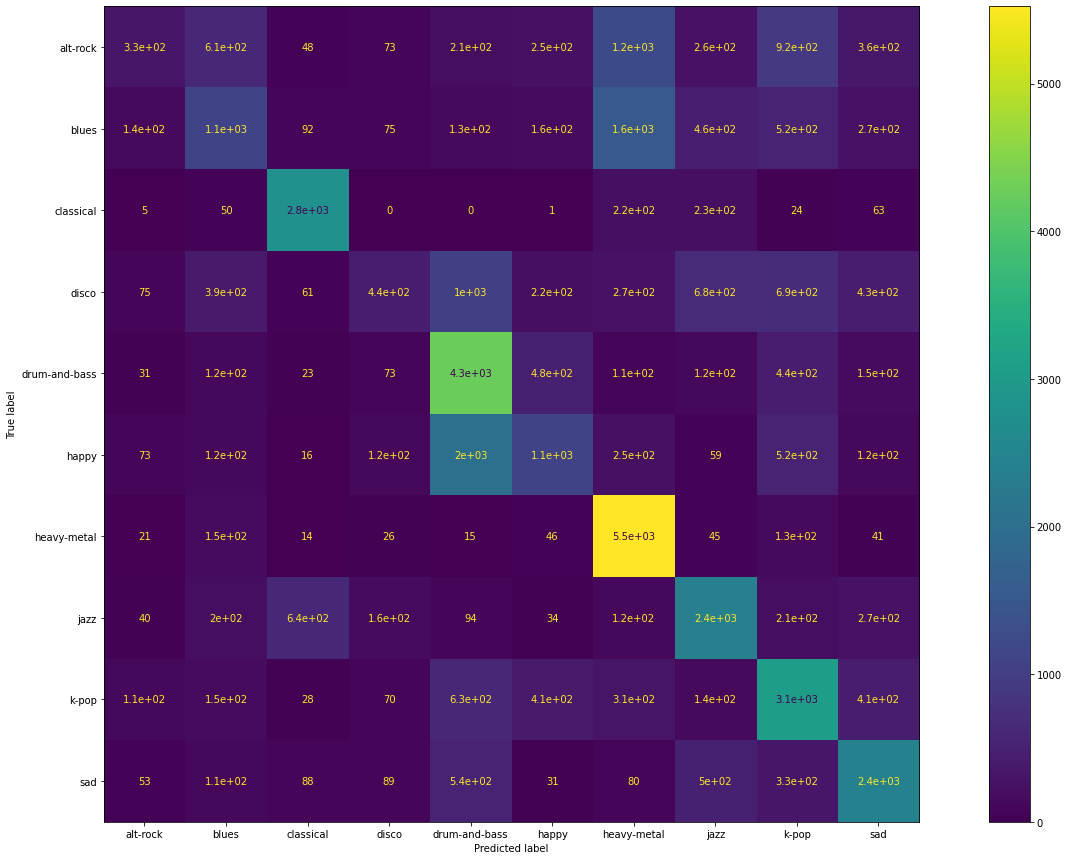

In [ ]:
plot_confusion_matrix(clf, X_test, Y_test)

### RBF

In [ ]:
svm = svm.SVC(C = 10, kernel = 'rbf', gamma = 0.01, class_weight = 'balanced')
svm.fit(X_train, Y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test_prediction = svm.predict(X_test)
print(accuracy_score(Y_test, test_predictions))

0.5047209377352403


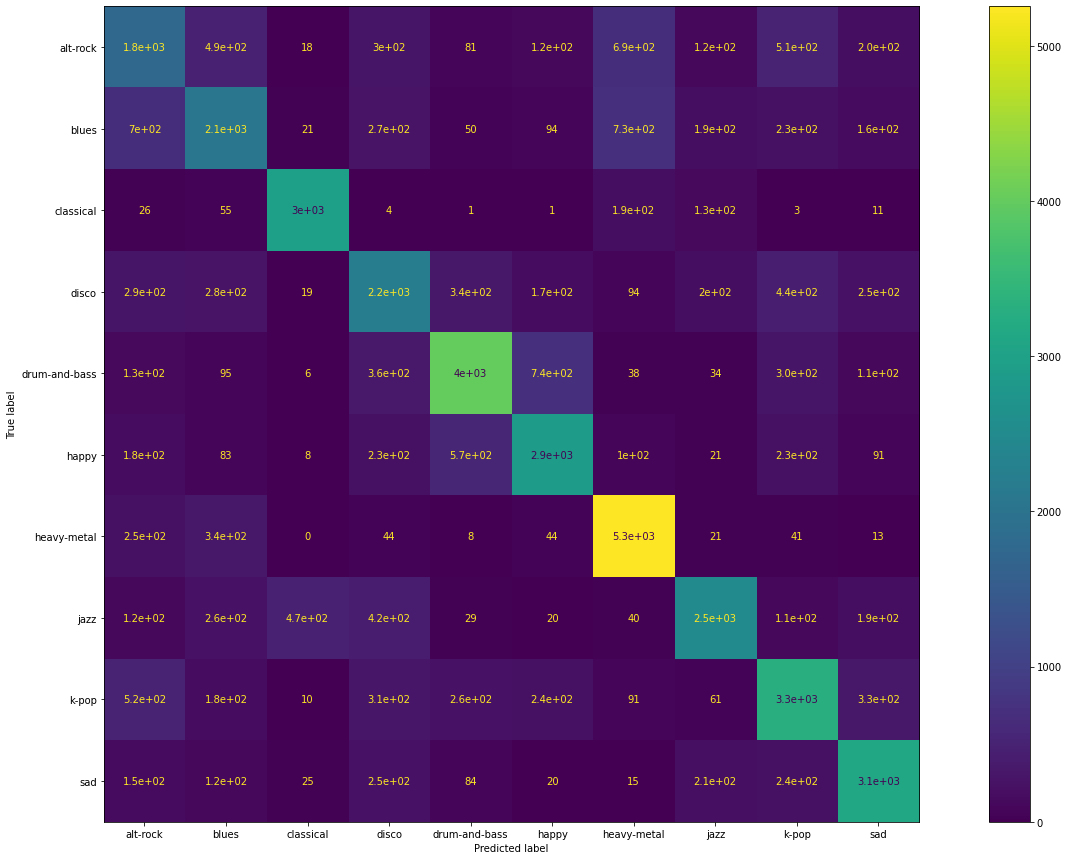

In [ ]:
plot_confusion_matrix(svm, X_test, Y_test)